<a href="https://colab.research.google.com/github/xanasa14/TranferLearning/blob/master/Copy_of_10_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

In [85]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import knifey

In [0]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop

In [88]:
tf.__version__

'1.15.0'

In [0]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [0]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [0]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [0]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [0]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

In [0]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/drive/My Drive/TLFile/')

import knifey 


In [97]:
knifey.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [98]:
knifey.copy_files()

Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl
- Copied training-set to: data/knifey-spoony/train/
- Copied test-set to: data/knifey-spoony/test/


In [0]:
train_dir = knifey.train_dir
test_dir = knifey.test_dir

In [102]:
model = VGG16(include_top=True, weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [108]:
input_shape = model.layers[1].output_shape[1:3]
print(input_shape)

(224, 224)


In [0]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [0]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [0]:
batch_size = 20

In [0]:
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

In [113]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 4170 images belonging to 3 classes.


In [114]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 530 images belonging to 3 classes.


In [115]:
steps_test = generator_test.n / batch_size
steps_test

26.5

In [0]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [0]:
cls_train = generator_train.classes
cls_test = generator_test.classes

Get the class-names for the dataset.

In [118]:
class_names = list(generator_train.class_indices.keys())
class_names

['forky', 'knifey', 'spoony']

In [119]:
num_classes = generator_train.num_classes
num_classes

3

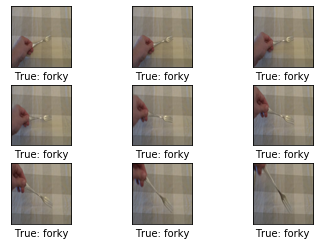

In [120]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [0]:
from sklearn.utils.class_weight import compute_class_weight

In [0]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [123]:
class_weight

array([1.39839034, 1.14876033, 0.70701933])

In [124]:
class_names

['forky', 'knifey', 'spoony']

In [0]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

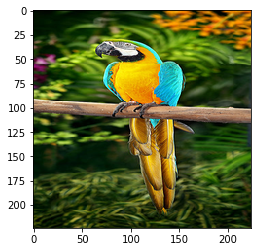

23.42% : knot
12.41% : macaw
11.89% : coral_reef
10.28% : snorkel
 8.28% : gar


In [127]:

predict(image_path='/content/drive/My Drive/TLFile/parrot.jpg')



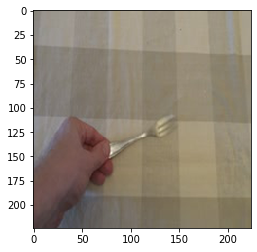

50.31% : shower_curtain
17.08% : handkerchief
12.75% : mosquito_net
 2.87% : window_shade
 1.32% : toilet_tissue


In [128]:
predict(image_path=image_paths_train[0])

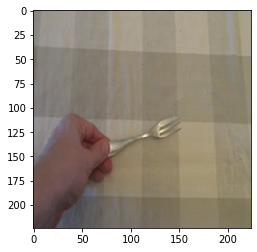

45.08% : shower_curtain
21.84% : mosquito_net
11.55% : handkerchief
 2.02% : window_shade
 0.91% : Windsor_tie


In [129]:
predict(image_path=image_paths_train[1])

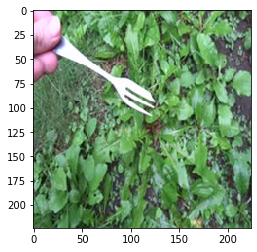

26.75% : spoonbill
 7.06% : black_stork
 7.04% : wooden_spoon
 4.21% : limpkin
 3.72% : paddle


In [130]:
predict(image_path=image_paths_test[0])

In [131]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
transfer_layer = model.get_layer('block5_pool')

In [133]:
transfer_layer.output

<tf.Tensor 'block5_pool_4/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [0]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [0]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

In [0]:
optimizer = Adam(lr=1e-5)

In [0]:
loss = 'categorical_crossentropy'

In [0]:
metrics = ['categorical_accuracy']

In [0]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [140]:
print_layer_trainable()

True:	input_5
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [0]:
conv_model.trainable = False

In [0]:
for layer in conv_model.layers:
    layer.trainable = False

In [143]:
print_layer_trainable()

False:	input_5
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [0]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [0]:
epochs = 20
steps_per_epoch = 100

Training the new model is just a single function call in the Keras API. This takes about 6-7 minutes on a GTX 1070 GPU.

In [0]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - 1320s 13s/step - loss: 1.1628 - categorical_accuracy: 0.4495 - val_loss: 0.8226 - val_categorical_accuracy: 0.6321
Epoch 2/20
 96/100 [===========================>..] - ETA: 42s - loss: 0.9860 - categorical_accuracy: 0.5120

Keras records the performance metrics at the end of each "epoch" so they can be plotted later. This shows that the loss-value for the training-set generally decreased during training, but the loss-values for the test-set were a bit more erratic. Similarly, the classification accuracy generally improved on the training-set while it was a bit more erratic on the test-set.

In [0]:
plot_training_history(history)

After training we can also evaluate the new model's performance on the test-set using a single function call in the Keras API.

In [0]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [0]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 78.68%


We can plot some examples of mis-classified images from the test-set. Some of these images are also difficult for a human to classify.

The confusion matrix shows that the new model is especially having problems classifying the forky-class.

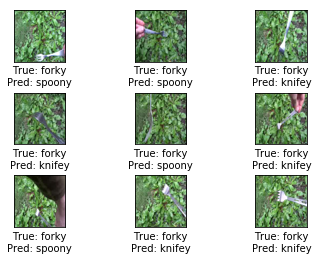

Confusion matrix:
[[140   5   6]
 [ 47  86   4]
 [ 36  15 191]]
(0) forky
(1) knifey
(2) spoony


In [0]:
example_errors()

## Fine-Tuning

In Transfer Learning the original pre-trained model is locked or frozen during training of the new classifier. This ensures that the weights of the original VGG16 model will not change. One advantage of this, is that the training of the new classifier will not propagate large gradients back through the VGG16 model that may either distort its weights or cause overfitting to the new dataset.

But once the new classifier has been trained we can try and gently fine-tune some of the deeper layers in the VGG16 model as well. We call this Fine-Tuning.

It is a bit unclear whether Keras uses the `trainable` boolean in each layer of the original VGG16 model or if it is overrided by the `trainable` boolean in the "meta-layer" we call `conv_layer`. So we will enable the `trainable` boolean for both `conv_layer` and all the relevant layers in the original VGG16 model.

In [0]:
conv_model.trainable = True

We want to train the last two convolutional layers whose names contain 'block5' or 'block4'.

In [0]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

We can check that this has updated the `trainable` boolean for the relevant layers.

In [0]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


We will use a lower learning-rate for the fine-tuning so the weights of the original VGG16 model only get changed slowly.

In [0]:
optimizer_fine = Adam(lr=1e-7)

Because we have defined a new optimizer and have changed the `trainable` boolean for many of the layers in the model, we need to recompile the model so the changes can take effect before we continue training.

In [0]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

The training can then be continued so as to fine-tune the VGG16 model along with the new classifier.

In [0]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - 27s 273ms/step - loss: 0.4715 - categorical_accuracy: 0.8105 - val_loss: 0.5107 - val_categorical_accuracy: 0.7717
Epoch 2/20
100/100 [==============================] - 24s 241ms/step - loss: 0.4656 - categorical_accuracy: 0.8067 - val_loss: 0.5141 - val_categorical_accuracy: 0.7717
Epoch 3/20
100/100 [==============================] - 25s 252ms/step - loss: 0.4359 - categorical_accuracy: 0.8210 - val_loss: 0.5059 - val_categorical_accuracy: 0.7717
Epoch 4/20
100/100 [==============================] - 24s 237ms/step - loss: 0.4324 - categorical_accuracy: 0.8355 - val_loss: 0.5057 - val_categorical_accuracy: 0.7736
Epoch 5/20
100/100 [==============================] - 25s 248ms/step - loss: 0.4243 - categorical_accuracy: 0.8340 - val_loss: 0.4981 - val_categorical_accuracy: 0.7792
Epoch 6/20
100/100 [==============================] - 24s 241ms/step - loss: 0.4224 - categorical_accuracy: 0.8395 - val_loss: 0.5045 - val_categorical_acc

We can then plot the loss-values and classification accuracy from the training. Depending on the dataset, the original model, the new classifier, and hyper-parameters such as the learning-rate, this may improve the classification accuracies on both training- and test-set, or it may improve on the training-set but worsen it for the test-set in case of overfitting. It may require some experimentation with the parameters to get this right.

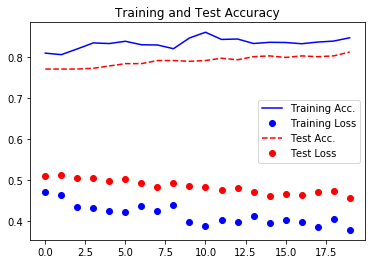

In [0]:
plot_training_history(history)

In [0]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [0]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 81.32%


We can plot some examples of mis-classified images again, and we can also see from the confusion matrix that the model is still having problems classifying forks correctly.

A part of the reason might be that the training-set contains only 994 images of forks, while it contains 1210 images of knives and 1966 images of spoons. Even though we have weighted the classes to compensate for this imbalance, and we have also augmented the training-set by randomly transforming the images in different ways during training, it may not be enough for the model to properly learn to recognize forks.

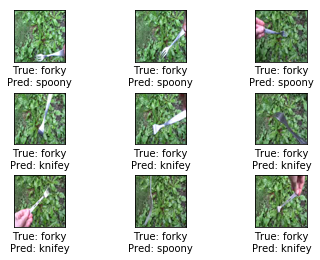

Confusion matrix:
[[138   6   7]
 [ 40  95   2]
 [ 33  11 198]]
(0) forky
(1) knifey
(2) spoony


In [0]:
example_errors()

## Conclusion

This tutorial showed how to use the Keras API for TensorFlow to do both Transfer Learning and Fine-Tuning of the pre-trained VGG16 model on a new dataset. It is much easier to implement this using the Keras API rather than directly in TensorFlow.

Whether Fine-Tuning improves the classification accuracy over just using Transfer Learning depends on the pre-trained model, the transfer-layer you choose, your dataset, and how you train the new model. You may experience improved performance from the fine-tuning, or you may experience worse performance if the fine-tuned model is overfitting your training-data.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook and the other files before making any changes.

* Try using other layers in the VGG16 model as the transfer layer. How does it affect the training and classification accuracy?
* Change the new classification layers we added. Can you improve the classification accuracy by either increasing or decreasing the number of nodes in the fully-connected / dense layer?
* What happens if you remove the Dropout-layer in the new classifier?
* Change the learning-rates for both Transfer Learning and Fine-Tuning.
* Try fine-tuning on the whole VGG16 model instead of just the last few layers. How does it affect the classification accuracy on the training- and test-sets? Why?
* Try doing the fine-tuning from the beginning so the new classification layers are trained from scratch along with all the convolutional layers of the VGG16 model. You may need to lower the learning-rate for the optimizer.
* Add a few images from the test-set to the training-set. Does that improve performance?
* Try deleting some of the knifey and spoony images from the training-set so the classes all have the same number of images. Does that improve the numbers in the confusion-matrix?
* Use another dataset.
* Use another pre-trained model available from Keras.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.